In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)#print()

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from matplotlib import pyplot as plt
import math, os, re, warnings, random
from sklearn.utils import class_weight
from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras import optimizers, applications, Sequential, losses, metrics
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,LearningRateScheduler

In [5]:
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = "1"
    
    
seed = 0
seed_everything(seed)
warnings.filterwarnings('ignore')
strategy = tf.distribute.get_strategy()
AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync 
print('# REPLICAS: {}'.format(REPLICAS))

# REPLICAS: 1


In [6]:
BATCH_SIZE = 32 * REPLICAS
LEARNING_RATE = 3e-3 * REPLICAS
EPOCHS = 32
HEIGHT = 450
WIDTH = 450
CHANNELS = 3
ES_PATIENCE = 10
AUG_BATCH=BATCH_SIZE
IMAGE_SIZE=[HEIGHT,WIDTH]

In [7]:
print(BATCH_SIZE)
print(LEARNING_RATE)

32
0.003


In [8]:
# GCS_PATH = KaggleDatasets().get_gcs_path('leukemia-classification')
GCS_PATH = '../input/leukemia-classification/'

In [9]:
train_dataset_0_all = glob.glob(GCS_PATH + '/C-NMC_Leukemia/training_data/fold_0/all/*.bmp')
train_dataset_0_hem = glob.glob(GCS_PATH + '/C-NMC_Leukemia/training_data/fold_0/hem/*.bmp')
train_dataset_1_all = glob.glob(GCS_PATH + '/C-NMC_Leukemia/training_data/fold_1/all/*.bmp')
train_dataset_1_hem = glob.glob(GCS_PATH + '/C-NMC_Leukemia/training_data/fold_1/hem/*.bmp')
train_dataset_2_all = glob.glob(GCS_PATH + '/C-NMC_Leukemia/training_data/fold_2/all/*.bmp')
train_dataset_2_hem = glob.glob(GCS_PATH + '/C-NMC_Leukemia/training_data/fold_2/hem/*.bmp')

In [10]:
len(train_dataset_0_all)

2397

In [11]:
len(train_dataset_0_hem)

1130

In [13]:
# Include Validation data as well :-

test_data=pd.read_csv(GCS_PATH + '/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data_labels.csv')

at = test_data[test_data['labels'] == 1]
ht = test_data[test_data['labels'] == 0]

test_PATH = GCS_PATH + '/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/'
ATL = [test_PATH +  i for i in list(at.new_names)]
HTL = [test_PATH +  i for i in list(ht.new_names)]

In [14]:
# Merging here:-

A=[]
H=[]

A.extend(train_dataset_0_all)
#A.extend(train_dataset_1_all)
#A.extend(train_dataset_2_all)


H.extend(train_dataset_0_hem)
H.extend(train_dataset_1_hem)
#H.extend(train_dataset_2_hem)


print(len(A))
print(len(H))

# Create labels :-
Label_A = [1]*len(A)
Label_H = [0]*len(H)

# Converting to pandas dataframe for easier access:-
A.extend(H)
Label_A.extend(Label_H)
df = pd.DataFrame({'path':A, 'label':Label_A})
df = df.sample(frac=1).reset_index(drop=True)

FILENAMES = df['path']
LABELS = df['label']

print('Final Merged Data:-')
df

2397
2293
Final Merged Data:-


,path,label
0,../input/leukemia-classification//C-NMC_Leukem...,1
1,../input/leukemia-classification//C-NMC_Leukem...,1
2,../input/leukemia-classification//C-NMC_Leukem...,0
3,../input/leukemia-classification//C-NMC_Leukem...,0
4,../input/leukemia-classification//C-NMC_Leukem...,1
...,...,...
4685,../input/leukemia-classification//C-NMC_Leukem...,1
4686,../input/leukemia-classification//C-NMC_Leukem...,0
4687,../input/leukemia-classification//C-NMC_Leukem...,1
4688,../input/leukemia-classification//C-NMC_Leukem...,0


In [16]:
print(len(A))
print(len(H))
m=len(A)
k=len(H)

4690
2293


In [15]:
"""import numpy as np
import matplotlib.pyplot as plt
# Dataset generation
data_dict = {'All':m, 'Hem':k}
courses = list(df.keys())#data_dict
values = list(df.values())#)#data_dict
fig = plt.figure(figsize = (5,3))
#  Bar plot
plt.bar(courses, values, color =['red','green'],
        width = 0.5)
plt.xlabel("Classes of images from dataset")
plt.ylabel("No. of images")
plt.title("Data Set class count")
plt.show()

"""

'import numpy as np\nimport matplotlib.pyplot as plt\n# Dataset generation\ndata_dict = {\'All\':m, \'Hem\':k}\ncourses = list(df.keys())#data_dict\nvalues = list(df.values())#)#data_dict\nfig = plt.figure(figsize = (5,3))\n#  Bar plot\nplt.bar(courses, values, color =[\'red\',\'green\'],\n        width = 0.5)\nplt.xlabel("Classes of images from dataset")\nplt.ylabel("No. of images")\nplt.title("Data Set class count")\nplt.show()\n\n'

In [17]:
from sklearn.utils import compute_class_weight
cw = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(LABELS),
                                        y = LABELS                                                   
                                    )
cw = {0:cw[0], 1:cw[1]}

cw

{0: 1.0226777147841255, 1: 0.9783062161034627}

In [18]:
# Define Augmentation function:-
def data_augment(image, label):
    
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)# 0 to 1 floating number
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel = tf.random.uniform([], 0, 1.0, dtype=tf.float32)    
    p_shear = tf.random.uniform([], 0, 1.0, dtype=tf.float32)#break off or cause to break off, owing to a structural strain.
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_flip_left_right(image)
    
    if p_spatial > .75:
        image = tf.image.transpose(image)#?? jodi amder 0 er perentage .75 transpose=x,y values swapping
        
    if p_pixel >= .2:
        if p_pixel >= .8:
            image = tf.image.random_saturation(image, lower=.7, upper=1.3)
        elif p_pixel >= .6:
            image = tf.image.random_contrast(image, lower=.8, upper=1.2)
        elif p_pixel >= .4:
            image = tf.image.random_brightness(image, max_delta=.1)
        else:
            image = tf.image.adjust_gamma(image, gamma=.6)
            
    if p_crop > .7:
        if p_crop > .9:
            image = tf.image.central_crop(image, central_fraction=.6)
        elif p_crop > .8:
            image = tf.image.central_crop(image, central_fraction=.7)
        else:
            image = tf.image.central_crop(image, central_fraction=.8)
    elif p_crop > .4:
        crop_size = tf.random.uniform([], int(HEIGHT*.6), HEIGHT, dtype=tf.int32)
        image = tf.image.random_crop(image, size=[crop_size, crop_size, CHANNELS])
        
    image = tf.image.resize(image, size=[HEIGHT, WIDTH])
    image = tf.reshape(image, [HEIGHT, WIDTH, 3])
    
    return image, label

In [19]:
def parse_data(filename,label):
    image = tf.io.read_file(filename)
    image = tf.image.decode_bmp(image)
    image = tf.image.convert_image_dtype(image, tf.float32) /  0.45 
    image = tf.image.resize(image, IMAGE_SIZE)
    return image, tf.one_hot(label,2)

def load_dataset(filenames, labels ,ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False

    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(parse_data, num_parallel_calls=AUTO)
    return dataset

def get_dataset(FILENAMES,LABELS, ordered=False, repeated=False, augment=False):
    dataset = load_dataset(FILENAMES, LABELS, ordered=ordered)
    if augment:
        dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    if repeated:
        dataset = dataset.repeat()
    if not ordered:
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

In [20]:
import math
np.set_printoptions(threshold=15, linewidth=80)
CLASSES = [0,1]

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    labels = [str(i) for i in  numpy_labels]

    return numpy_images, labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 10.0
    SPACING = 0.01#.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = label
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        # image = cv2.imdecode(image,cv2.IMREA)
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    
    
# Model evaluation
def plot_metrics(history):
    metric_list = [m for m in list(history.keys()) if m is not 'lr']
    size = len(metric_list)//2
    fig, axes = plt.subplots(size, 1, sharex='col', figsize=(6, size * 4))#10
    if size > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    for index in range(len(metric_list)//2):
        metric_name = metric_list[index]
        val_metric_name = metric_list[index+size]
        axes[index].plot(history[metric_name], label='Train %s' % metric_name)
        axes[index].plot(history[val_metric_name], label='Validation %s' % metric_name)
        axes[index].legend(loc='best', fontsize=10)
        axes[index].set_title(metric_name)
        if 'loss' in metric_name:
            axes[index].axvline(np.argmin(history[metric_name]), linestyle='dashed')
            axes[index].axvline(np.argmin(history[val_metric_name]), linestyle='dashed', color='orange')
        else:
            axes[index].axvline(np.argmax(history[metric_name]), linestyle='dashed')
            axes[index].axvline(np.argmax(history[val_metric_name]), linestyle='dashed', color='orange')

    plt.xlabel('Epochs', fontsize=10)#16
    sns.despine()
    plt.show()

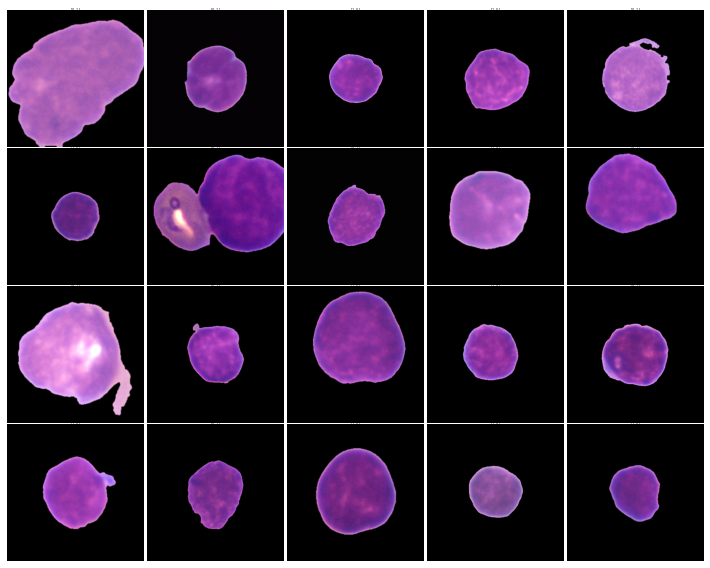

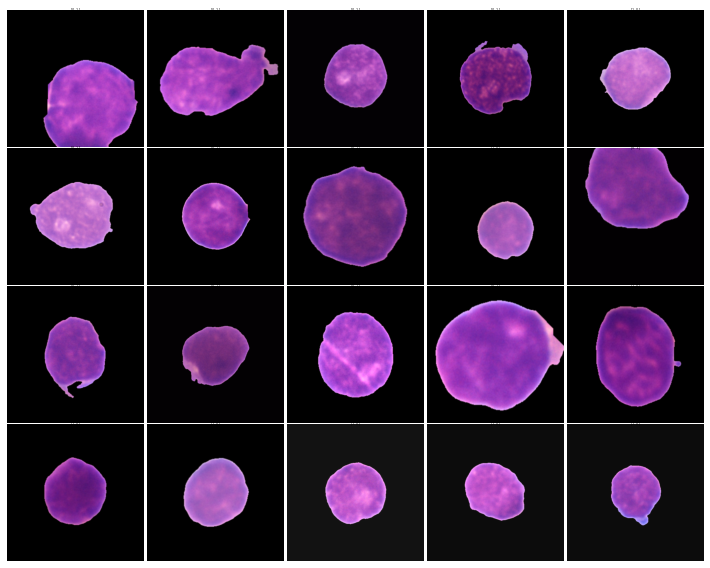

In [22]:
train_dataset = get_dataset(FILENAMES[:60],LABELS[:60], ordered=True,augment=True)#60
train_iter = iter(train_dataset.unbatch().batch(20))#10

display_batch_of_images(next(train_iter))
display_batch_of_images(next(train_iter))

Learning rate schedule: 1e-08 to 0.003 to 8.79e-06


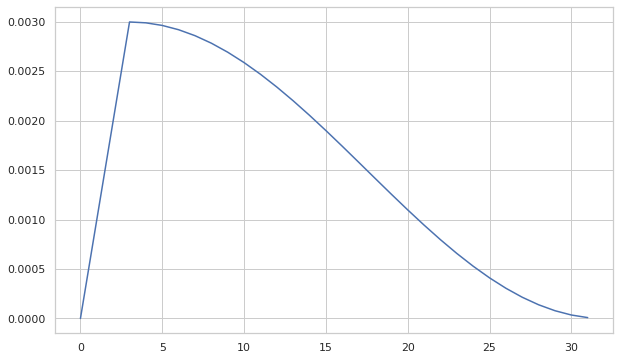

In [23]:
# Cosine Annealing:-
LR_START = 1e-8
LR_MIN = 1e-8
LR_MAX = LEARNING_RATE
LR_RAMPUP_EPOCHS = 3
LR_SUSTAIN_EPOCHS = 0
N_CYCLES = .5


def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        progress = (epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) / (EPOCHS - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)
        lr = LR_MAX * (0.5 * (1.0 + tf.math.cos(math.pi * N_CYCLES * 2.0 * progress)))
        if LR_MIN is not None:
            lr = tf.math.maximum(LR_MIN, lr)
            
    return lr

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]

sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(rng, y)

# print(f'{EPOCHS} total epochs and {NUM_TRAINING_IMAGES//BATCH_SIZE} steps per epoch')
print(f'Learning rate schedule: {y[0]:.3g} to {max(y):.3g} to {y[-1]:.3g}')

In [24]:
import tensorflow_addons as tfa
from tensorflow.python.keras.applications.resnet import ResNet50
#from keras.applications import ResNet50
#from keras_applications.resnet import ResNet50
# Model Architecture :-
def model_fn(input_shape, N_CLASSES):
    input_image = L.Input(shape=input_shape, name='input_image')
    base_model = tf.keras.applications.ResNet50(input_tensor=input_image, 
                                    include_top=False, 
                                    weights='imagenet', 
                                    pooling='avg')

    for layer in base_model.layers:
        if 'bn' in layer.name:
            layer.trainable = False
        else:
            layer.trainable = True
            
    model = tf.keras.Sequential([
        base_model,
        L.Dropout(.25),
        L.Dense(N_CLASSES, activation='sigmoid', name='output')
    ])

    optimizer = optimizers.Adam(lr=LEARNING_RATE)
    model.compile(optimizer=optimizer, 
                  loss='binary_crossentropy', 
                  metrics=['accuracy',tfa.metrics.F1Score(num_classes=2, average='weighted')])
    
    return model

In [ ]:
#model_fn.summary()

In [ ]:
# Cross Validated training loop:-
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
oof_pred = []; oof_labels = []; history_list = []
cv1 = cv2 = 0


for fold,(idxT, idxV) in enumerate(skf.split(FILENAMES,LABELS)):
    print(f'\nFOLD: {fold+1}')
    print(f'TRAIN: {len(idxT)} VALID: {len(idxV)}')
    STEPS_PER_EPOCH = len(idxT) // BATCH_SIZE
    
    
    K.clear_session()
    with strategy.scope():
        model = model_fn((None, None, CHANNELS), 2)
        
    model_path = f'model_{fold}.h5'
    es = EarlyStopping(monitor='val_f1_score', mode='max', 
                    patience=ES_PATIENCE, restore_best_weights=True, verbose=1)

    ## TRAIN
    history = model.fit(x=get_dataset(FILENAMES[idxT],LABELS[idxT], ordered=False, repeated=True, augment=True), 
                        validation_data=get_dataset(FILENAMES[idxV],LABELS[idxV] , ordered=True, repeated=False, augment=False), 
                        steps_per_epoch=STEPS_PER_EPOCH, 
                        callbacks=[es, LearningRateScheduler(lrfn ,verbose=0)], 
                        epochs=EPOCHS,  
                        verbose=1,
                        class_weight = cw).history
      
    model.save_weights(model_path)
    history_list.append(history)
    # Save last model weights

    
    ## RESULTS
    print(f"#### FOLD {fold+1} OOF Accuracy = {np.max(history['val_accuracy']):.3f}")
    cv1 += np.max(history['val_accuracy'])
    cv2 += np.max(history['val_f1_score'])
    del model
    
print(f'### Avg. Accuracy = {cv1/7.0} \n ### Avg. Weighted F1 = {cv2/7.0}')


FOLD: 1
TRAIN: 3752 VALID: 938
94781440/94765736 [==============================] - 0s 0us/step
Epoch 1/32


2022-09-04 18:11:01.969568: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 886 of 2048
2022-09-04 18:11:11.939434: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1879 of 2048
2022-09-04 18:11:14.045611: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.
2022-09-04 18:11:15.828444: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


117/117 [==============================] - 140s 891ms/step - loss: 0.9385 - accuracy: 0.5000 - f1_score: 0.3433 - val_loss: 0.8417 - val_accuracy: 0.5117 - val_f1_score: 0.3464
Epoch 2/32
117/117 [==============================] - 102s 876ms/step - loss: 1.2776 - accuracy: 0.4981 - f1_score: 0.4962 - val_loss: 0.6937 - val_accuracy: 0.4883 - val_f1_score: 0.3204
Epoch 3/32
117/117 [==============================] - 103s 878ms/step - loss: 0.6983 - accuracy: 0.5005 - f1_score: 0.4733 - val_loss: 0.6997 - val_accuracy: 0.5117 - val_f1_score: 0.3464
Epoch 4/32
117/117 [==============================] - 102s 875ms/step - loss: 1147608.3750 - accuracy: 0.4936 - f1_score: 0.4746 - val_loss: 5570300.5000 - val_accuracy: 0.4883 - val_f1_score: 0.0000e+00
Epoch 5/32
117/117 [==============================] - 103s 878ms/step - loss: 2586663680.0000 - accuracy: 0.4971 - f1_score: 0.5054 - val_loss: 533634400.0000 - val_accuracy: 0.4883 - val_f1_score: 0.6668
Epoch 6/32
117/117 [==================

2022-09-04 18:37:31.370214: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 733 of 2048


In [ ]:
# Plot metrics:-
for fold, history in enumerate(history_list):
    print(f'\nFOLD: {fold+1}')
    plot_metrics(history)

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
AUC = history.history['auc']
val_AUC = history.history['val_auc']

epochs = range(1,len(acc)+1)

plt.figure()
plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.ylim([0, 1.3])
plt.savefig('Accuracy.png')

plt.figure()
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.ylim([0, 1.3])
plt.savefig('Loss.png')

plt.figure()
plt.plot(epochs, AUC, 'b', label = 'Training AUC')
plt.plot(epochs, val_AUC, 'r', label='Validation AUC')
plt.title('Training and validation AUC')
plt.legend()
plt.ylim([0, 1.3])
plt.savefig('AUC.png')


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes, figname,
 normalize=False,
 title='Confusion matrix',
 cmap=plt.cm.Blues):
#  “””
#  This function prints and plots the confusion matrix.
#  Normalization can be applied by setting `normalize=True`.
#  “””
 import numpy as np
 import matplotlib.pyplot as plt
 import itertools
 if normalize:
  cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
  print('Normalized confusion matrix')
 else:
  print('Confusion matrix, without normalization')
  
 plt.figure(figsize=(8,8))
 plt.imshow(cm, interpolation='nearest', cmap=cmap)
 plt.title(title)
 #plt.colorbar()
 tick_marks = np.arange(len(classes))
 plt.xticks(tick_marks, classes, rotation=90)
 plt.yticks(tick_marks, classes)
 fmt = '.2f' if normalize else 'd'
 thresh = cm.max() / 2.
 for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, format(cm[i, j], fmt),
  horizontalalignment='center',
  color='white' if cm[i, j] > thresh else 'black')
 plt.ylabel('True label')
 plt.xlabel('Predicted label')
 plt.tight_layout()
 plt.savefig(figname)

In [ ]:
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

cm = confusion_matrix(test_generator.classes, y_pred)

In [ ]:
print(cm)